**Importing the Required Modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer, RobustScaler

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import ShuffleSplit,  cross_val_score

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 4)
pd.set_option("plotting.backend", "matplotlib")

from google.colab import drive
drive.mount('/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /drive


**Utility Functions**

In [3]:
def regression_metrics_report(y_pred, y, n_features, n_samples):
  errors = abs(y_pred - y)
  RMSE = float(format(np.sqrt(mean_squared_error(y_pred, y)), ".3f"))
  MSE = mean_squared_error(y, y_pred)
  MAE = mean_absolute_error(y, y_pred)
  R2 = r2_score(y, y_pred, multioutput="variance_weighted")
  adjR2 = 1 - ((1 - R2) * (n_samples - 1)) / (n_samples - n_features - 1)

  print(f"Average absolute error: {np.mean(errors):.3f}")
  print(f"Root Mean Squared Error (RMSE): {RMSE:.3f}")
  print(f"Mean Squared Error (MSE): {MSE:.3f}")
  print(f"Mean Absolute Error (MAE): {MAE:.3f}")
  print(f"R2_Score: {R2:.3f}")
  print(f"Adjusted R2: {adjR2:.3f}")


**Freeze Random State**

In [4]:
np.random.seed(35)

**Installing the Required Modules**

In [5]:
!pip install optuna
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **1. Data Transformers**

In [6]:
TRAIN_PATH = "/drive/My Drive/rul/train_telemetry.csv"
TEST_PATH = "/drive/My Drive/rul/test_telemetry.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

## **1.1 Datatime Transformers**

In [7]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

## **1.2 Utility Transformers**

In [8]:
def identy_transformer():
  return FunctionTransformer(lambda x: x)

## **1.3 Full Dataset Transformer**

In [9]:
transform = make_column_transformer(
   (OrdinalEncoder(), ["age", "model"]),
   (sin_transformer(365), ["time_in_cycles"]),
   (cos_transformer(365), ["time_in_cycles"]),
   (RobustScaler(),
     ["voltmean_24h","rotatemean_24h","pressuremean_24h",
      "vibrationmean_24h", "voltsd_24h", "rotatesd_24h",
      "pressuresd_24h", "vibrationsd_24h", "voltmean_5d", "rotatemean_5d",
      "pressuremean_5d", "vibrationmean_5d", "voltsd_5d", "rotatesd_5d",
      "pressuresd_5d","vibrationsd_5d", "volts_entropy", "volts_benford",
      "volts_cidce", "volts_lzc", "press_max", "press_below", "press_above",
      "press_entropy", "press_benford", "press_cidce", "press_lzc",
      "vibra_max", "vibra_below", "vibra_above", "vibra_entropy",
      "vibra_benford", "vibra_cidce", "vibra_lzc", "rotate_max", "rotate_below",
      "rotate_above", "rotate_entropy", "rotate_benford", "rotate_cidce",
       "rotate_lzc","volts_max", "volts_below", "volts_above", "DI",
      ]),
   (identy_transformer(), ["error1", "error2","error3", "error4", "error5",
                           "comp1", "comp2", "comp3", "comp4"]))

# **2. Regressor Fitting**

## **2.1 Pipeline Creation**

In [10]:
 from xgboost import XGBRegressor

 model = XGBRegressor()
 pipeline= make_pipeline(transform, model)

## **2.2 Model Fitting and Data Anonymization**

In [11]:
X_train = train_df
X_test  = test_df

Y_train = X_train["RUL_I"].values.astype(np.float).ravel()
Y_test = X_test["RUL_I"].values.astype(np.float).ravel()

#data anonymization
dropped_lst = ["machineID", 'datetime', 'RULWeek', 'failure', 'failed',
                'RUL', 'RUL_I']

X_train = X_train.drop(dropped_lst, axis=1)
X_test = X_test.drop(dropped_lst, axis=1)

pipeline.fit(X_train, Y_train);

Y_pred = pipeline.predict(X_test)

k = X_test.shape[1]
n = len(X_test)

regression_metrics_report(Y_pred, Y_test, k, n)

Average absolute error: 13.950
Root Mean Squared Error (RMSE): 18.733
Mean Squared Error (MSE): 350.941
Mean Absolute Error (MAE): 13.950
R2_Score: 0.696
Adjusted R2: 0.694


И так мы получили хорошее значение метрик $R^{2}$ и $adjR^{2}$ уже у дефолтного регрессора

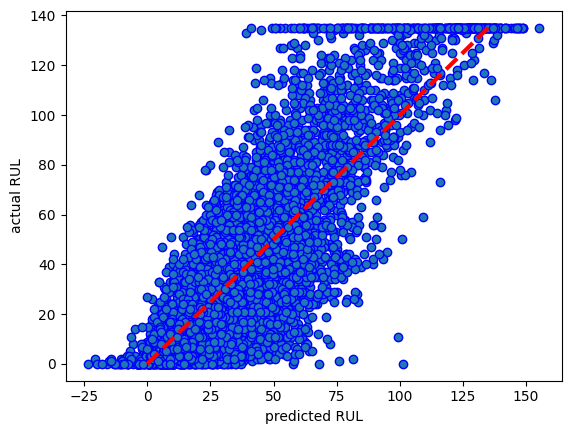

In [12]:
fig, ax = plt.subplots()
ax.scatter(Y_pred, Y_test, edgecolors=(0, 0, 1))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=3)
ax.set_xlabel('predicted RUL')
ax.set_ylabel('actual RUL')
plt.show()

По сравнению с одиночным деревом ошибки предсказаний меньше зависять от значений RUL, иными словами наша модель одинаково ошибается как когда до выхода из строя остался незначительный запас времени так и до выхода из строя у нас еще много времени

## **2.3 Features Importance**

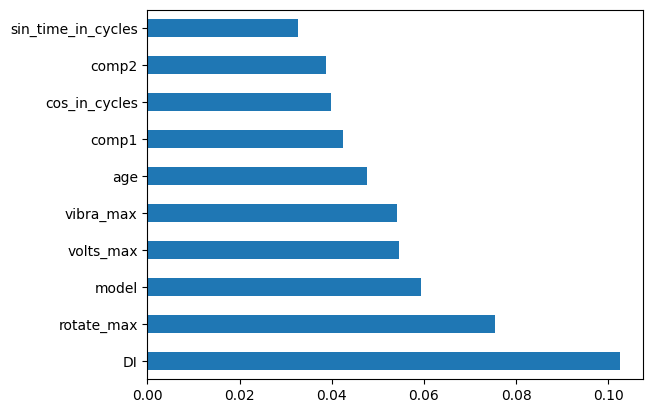

In [13]:
N_LARGEST = 10

TRANSFORM_COLUMN_NAMES = [
      "age", "model", "sin_time_in_cycles", "cos_in_cycles",
      "voltmean_24h","rotatemean_24h","pressuremean_24h",
      "vibrationmean_24h", "voltsd_24h", "rotatesd_24h",
      "pressuresd_24h", "vibrationsd_24h", "voltmean_5d", "rotatemean_5d",
      "pressuremean_5d", "vibrationmean_5d", "voltsd_5d", "rotatesd_5d",
      "pressuresd_5d","vibrationsd_5d", "volts_entropy", "volts_benford",
      "volts_cidce", "volts_lzc", "press_max", "press_below", "press_above",
      "press_entropy", "press_benford", "press_cidce", "press_lzc",
      "vibra_max", "vibra_below", "vibra_above", "vibra_entropy",
      "vibra_benford", "vibra_cidce", "vibra_lzc", "rotate_max", "rotate_below",
      "rotate_above", "rotate_entropy", "rotate_benford", "rotate_cidce",
      "rotate_lzc","volts_max", "volts_below", "volts_above", "DI",
      "error1", "error2","error3", "error4", "error5",
      "comp1", "comp2", "comp3", "comp4"]

feat_importances = pd.Series(model.feature_importances_, TRANSFORM_COLUMN_NAMES)
feat_importances.nlargest(N_LARGEST).plot(kind='barh')
plt.show()

Также поменялось распределение важных параметров теперь основную роль для предсказаний играют физические измерения

# **3. Regressor Finetuning**

Попробуем найти оптимальные значения параметров максимизирующие $R^{2}$

## **3.1 Objective Function**

In [14]:
def objective(trial):
  param = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.01, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1.0),
  }
  model = XGBRegressor(**param, tree_method='gpu_hist', gpu_id=0)
  pipeline = make_pipeline(transform, model)
  cv = ShuffleSplit(n_splits=15,  random_state=42)

  score = cross_val_score(pipeline,  train_df, Y_train,  scoring="r2",  cv=cv)
  final_score = score.mean()
  return final_score

## **3.2 Finetuning**

Под оптимальными гиперпараметрами будем понимать те которые максимизируют  $R^{2}$

In [15]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

params = study.best_trial.params

print('Found params:')
print(params)

[I 2023-06-17 13:21:37,806] A new study created in memory with name: no-name-3ab0825c-66f9-4342-8867-f8e2c4d92bce
[I 2023-06-17 13:22:13,039] Trial 0 finished with value: 0.702621252492576 and parameters: {'max_depth': 9, 'learning_rate': 0.43576448246881333, 'n_estimators': 793, 'min_child_weight': 10, 'gamma': 0.3891411618206203, 'colsample_bytree': 0.6619029032369338, 'reg_alpha': 0.5935122852131101, 'reg_lambda': 0.20459913529673757}. Best is trial 0 with value: 0.702621252492576.
[I 2023-06-17 13:22:26,717] Trial 1 finished with value: 0.4907275605800319 and parameters: {'max_depth': 2, 'learning_rate': 0.7444617929332261, 'n_estimators': 671, 'min_child_weight': 1, 'gamma': 0.0874010174331946, 'colsample_bytree': 0.8332129786928041, 'reg_alpha': 0.9175409273183811, 'reg_lambda': 0.554768099237347}. Best is trial 0 with value: 0.702621252492576.
[I 2023-06-17 13:23:04,454] Trial 2 finished with value: 0.6952715525478302 and parameters: {'max_depth': 6, 'learning_rate': 0.427000283

Found params:
{'max_depth': 8, 'learning_rate': 0.06077455436675816, 'n_estimators': 797, 'min_child_weight': 4, 'gamma': 0.8197063593626484, 'colsample_bytree': 0.9776342964063931, 'reg_alpha': 0.3024900100643905, 'reg_lambda': 0.9794842745649157}


# **4. Regressor With Best Hyperparameters**

In [16]:
model = XGBRegressor(**params)
pipeline = make_pipeline(transform, model)

pipeline.fit(train_df, Y_train);

Y_pred = pipeline.predict(test_df).round()

k = test_df.shape[1]
n = len(test_df)

regression_metrics_report(Y_pred, Y_test, k, n)

Average absolute error: 10.367
Root Mean Squared Error (RMSE): 14.347
Mean Squared Error (MSE): 205.834
Mean Absolute Error (MAE): 10.367
R2_Score: 0.821
Adjusted R2: 0.820


После выполнения процедуры поиска гиперпараметров получили значительный прирост $R^{2}$ с одновременной уменьшением максимальной глубины у отдельных регрессоров

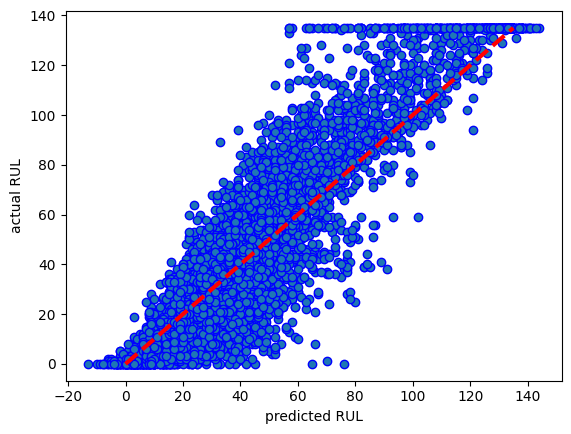

In [17]:
fig, ax = plt.subplots()
ax.scatter(Y_pred, Y_test, edgecolors=(0, 0, 1))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=3)
ax.set_xlabel('predicted RUL')
ax.set_ylabel('actual RUL')
plt.show()

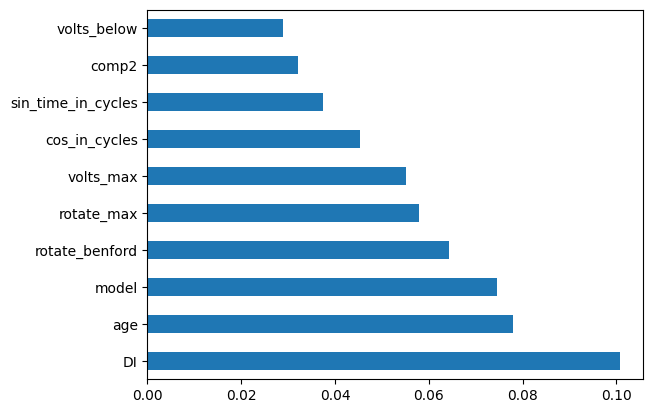

In [18]:
feat_importances = pd.Series(model.feature_importances_, TRANSFORM_COLUMN_NAMES)
feat_importances.nlargest(N_LARGEST).plot(kind='barh')
plt.show()

Очевидно изменились и веса признаков используемых для предсказаний? на первые места вышли качественные показатели для машины, но далее все также сохраняют свою значимость и физические измерения